<a href="https://colab.research.google.com/github/Afealete/FOXTROT-2-ASSIGNMENT-2/blob/main/Copy_of_FOXTROT_2_ASSIGNMENT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study – Banking & Loans in Ghana

In today’s competitive and digitally driven financial environment, the ability to predict credit risk is a strategic advantage. GhanaLoanConnect, a digital lending platform connecting borrowers to investors, is actively seeking data-driven solutions to reduce its rate of non-performing loans (NPLs). Rising default rates not only impact profitability but also weaken lender trust and reduce platform credibility

To address this challenge, this project proposes the development of a machine learning model that can predict the likelihood of a borrower defaulting on a loan. With accurate predictions, GhanaLoanConnect can proactively minimize risk, prioritize low-risk borrowers, and enhance portfolio performance.

## Import common libraries

In [4]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.2 MB/s eta 0:00:00


In [90]:
!pip install scikit-optimize

In [5]:
# to handle the data
import pandas as pd
import numpy as np

# to visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

# To preprocess the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder

# machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score

# for classification tasks
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


# metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import fairlearn for fairness assessment and mitigation
from fairlearn.metrics import MetricFrame,demographic_parity_difference,equalized_odds_difference
from fairlearn.reductions import GridSearch,EqualizedOdds #Using EqualizedOdds as constraint


## Load dataset

In [37]:
# Reading the dataset into the content folder
from google.colab import files
uploaded = files.upload()


data = pd.read_csv('/content/loan_borowwer_data.csv')
data



# 1. Define the sensitive attribute(s)
sensitive_attribute_name = 'fico' # Name for printing
A = data[[sensitive_attribute_name]] # Extract the sensitive attribute column(s)

# Exclude sensitive attribute from features
X = data.drop(['not.fully.paid', sensitive_attribute_name], axis=1)
y = data['not.fully.paid']

Saving loan_borowwer_data.csv to loan_borowwer_data.csv


# 1.Exploratory Data Analysis


In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   credit.policy            9578 non-null   int64  
 1   purpose                  9578 non-null   object 
 2   int.rate                 9578 non-null   float64
 3   installment              9578 non-null   float64
 4   log.annual.inc           9578 non-null   float64
 5   dti                      9578 non-null   float64
 6   fico                     9578 non-null   int64  
 7   days.with.cr.line        9578 non-null   float64
 8   revol.bal                9578 non-null   int64  
 9   revol.util               9578 non-null   float64
 10  inq.last.6mths           9578 non-null   int64  
 11  delinq.2yrs              9578 non-null   int64  
 12  pub.rec                  9578 non-null   int64  
 13  not.fully.paid           9578 non-null   int64  
 14  credit_age              

In [42]:
data.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,credit_age,loan_to_income,debt_to_income_adjusted,delinq_rate
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054,12.495253,0.005651,0.000272,0.014781
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676,6.840905,0.003657,0.000272,0.056634
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.490297,0.000041,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000,7.726027,0.002948,0.000104,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000,11.342352,0.004932,0.000209,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000,15.698630,0.007599,0.000364,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000,48.328653,0.045143,0.010016,1.667252


In [43]:
# Check for missing values
print(data.isnull().sum())

credit.policy              0
purpose                    0
int.rate                   0
installment                0
log.annual.inc             0
dti                        0
fico                       0
days.with.cr.line          0
revol.bal                  0
revol.util                 0
inq.last.6mths             0
delinq.2yrs                0
pub.rec                    0
not.fully.paid             0
credit_age                 0
loan_to_income             0
debt_to_income_adjusted    0
delinq_rate                0
dtype: int64


not.fully.paid
0    8045
1    1533
Name: count, dtype: int64


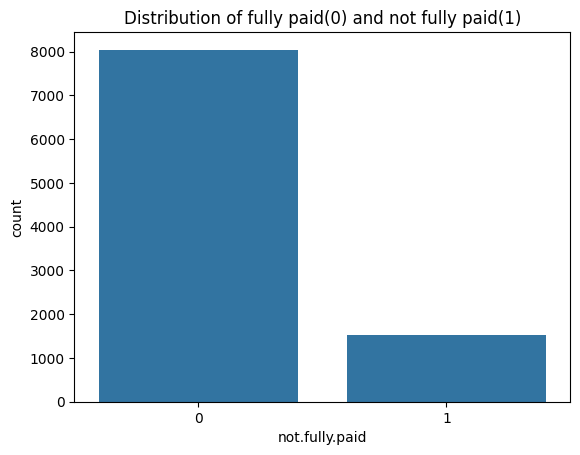

In [44]:
#count of fully paid and not fully paid clients
print(data['not.fully.paid'].value_counts())
# Visualize the distribution of the target variable (credit.policy)
sns.countplot(x='not.fully.paid', data=data)
plt.title('Distribution of fully paid(0) and not fully paid(1)')
plt.show()

## 2. Data Preprocessing

In [45]:
# One hot encoding for 'purpose' since is the only one with strings
data = pd.get_dummies(data, columns=['purpose'], drop_first=True)

# Verify the changes
data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,...,credit_age,loan_to_income,debt_to_income_adjusted,delinq_rate,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,...,15.451941,0.009754,0.000229,0.000000,False,True,False,False,False,False
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,...,7.561644,0.003511,0.000220,0.000000,True,False,False,False,False,False
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,...,12.904110,0.011464,0.000363,0.000000,False,True,False,False,False,False
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,...,7.397146,0.001910,0.000095,0.000000,False,True,False,False,False,False
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,...,11.139726,0.001274,0.000185,0.089769,True,False,False,False,False,False


Distribution of not fully paid:
not.fully.paid
0    8045
1    8045
Name: count, dtype: int64


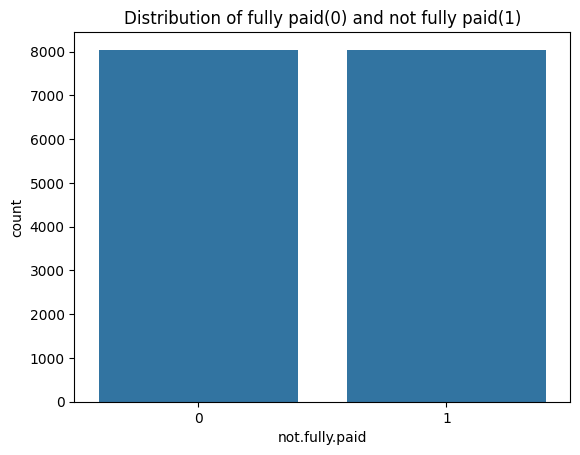

In [66]:
# Scaling to get equal distributions
from imblearn.over_sampling import RandomOverSampler

# Separate features and target
X = data.drop('not.fully.paid', axis=1)
y = data['not.fully.paid']

# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the training data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the oversampled minority class with the majority class
data_balanced = pd.concat([X_resampled, y_resampled])

# Display the new distribution
print("Distribution of not fully paid:")
print(y_resampled.value_counts())

# Visualizing the new distribution
sns.countplot(x=y_resampled)
plt.title('Distribution of fully paid(0) and not fully paid(1)')
plt.show()

([<matplotlib.patches.Wedge at 0x7e550b3c6c90>,
 [Text(-0.9638470616227687, 0.5300932387808346, '0'),
  Text(0.9638471079649895, -0.5300931545186429, '1')],
 [Text(-0.5257347608851465, 0.28914176660772795, '84.0%'),
  Text(0.5257347861627215, -0.2891417206465325, '16.0%')])

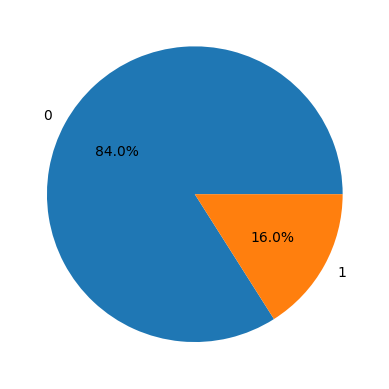

In [47]:
pct_defaulters = data['not.fully.paid'].value_counts(normalize=True)
plt.pie(pct_defaulters, labels=pct_defaulters.index, autopct='%1.1f%%')

## 3. Feature Engineering

In [58]:
# Debt-to-Income Ratio (DTI)
data["debt_to_income_ratio"] = data["installment"] / data["log.annual.inc"]

#Loan-to-income Ratio
data["loan_to_income"] = data["installment"] / np.exp(data["log.annual.inc"])

# Credit Utilization Ratio
data["credit_utilization"] = data["revol.bal"] / data["revol.util"]

# Payment-to-Income Ratio
data["payment_to_income_ratio"] = data["installment"] / data["log.annual.inc"]

# Check newly created features
print(data.head())


   credit.policy  int.rate  installment  log.annual.inc    dti  fico  \
0              1    0.1189       829.10       11.350407  19.48   737   
1              1    0.1071       228.22       11.082143  14.29   707   
2              1    0.1357       366.86       10.373491  11.63   682   
3              1    0.1008       162.34       11.350407   8.10   712   
4              1    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  ...  \
0        5639.958333      28854        52.1               0  ...   
1        2760.000000      33623        76.7               0  ...   
2        4710.000000       3511        25.6               1  ...   
3        2699.958333      33667        73.2               1  ...   
4        4066.000000       4740        39.5               0  ...   

   purpose_major_purchase  purpose_small_business  int_rate_fico  \
0                   False                   False        87.6293   
1                   Fa

In [59]:
data.isnull().sum()

,0
credit.policy,0
int.rate,0
installment,0
log.annual.inc,0
dti,0
fico,0
days.with.cr.line,0
revol.bal,0
revol.util,0
inq.last.6mths,0


In [61]:
data.fillna(data.median(), inplace=True)
data.isnull().sum()

,0
credit.policy,0
int.rate,0
installment,0
log.annual.inc,0
dti,0
fico,0
days.with.cr.line,0
revol.bal,0
revol.util,0
inq.last.6mths,0


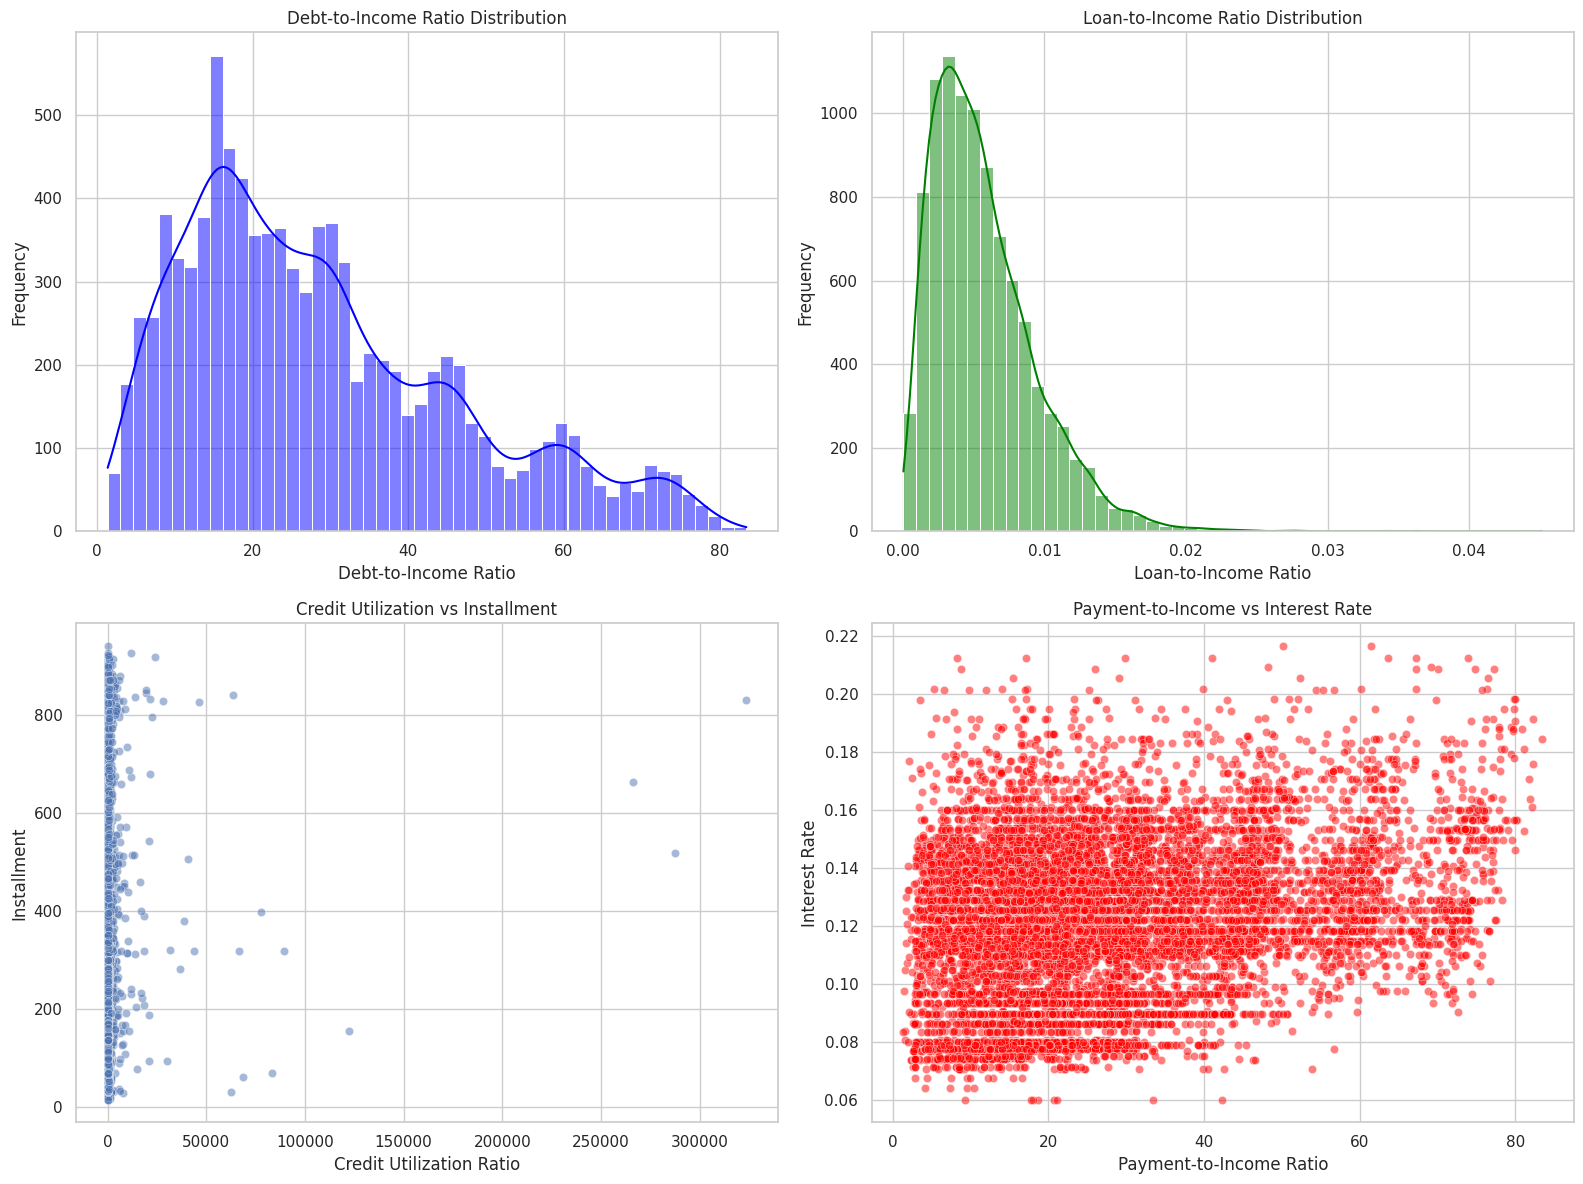

Debt-to-Income Analysis:
This histogram shows how much of a borrower's income is allocated to debt payments. A right-skewed distribution means most borrowers have lower debt-to-income ratios, but outliers with high values may indicate financial strain, increasing their risk of default.

Loan-to-Income Analysis:
This histogram visualizes the ratio of loan amounts relative to income. A high loan-to-income ratio indicates riskier borrowers who may struggle with repayments. A bell-shaped distribution suggests normal loan behavior, while a long tail indicates potential defaults.

Credit Utilization Analysis:
This scatter plot shows the relationship between credit utilization and installment amounts. A higher credit utilization ratio often means borrowers rely heavily on credit, which may signal financial distress. If we see a concentration of high utilization ratios with large installment payments, it may indicate defaulters.

Payment-to-Income Analysis:
This scatter plot compares the borro

In [74]:
# Visualization style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 12))

# **1. Debt-to-Income Ratio Distribution**
plt.subplot(2, 2, 1)
sns.histplot(data["debt_to_income_ratio"], bins=50, kde=True, color="blue")
plt.title("Debt-to-Income Ratio Distribution")
plt.xlabel("Debt-to-Income Ratio")
plt.ylabel("Frequency")

# **2. Loan-to-Income Ratio Distribution**
plt.subplot(2, 2, 2)
sns.histplot(data["loan_to_income"], bins=50, kde=True, color="green")
plt.title("Loan-to-Income Ratio Distribution")
plt.xlabel("Loan-to-Income Ratio")
plt.ylabel("Frequency")

# **3. Credit Utilization Ratio Scatter Plot vs Loan Amount**
plt.subplot(2, 2, 3)
sns.scatterplot(x=data["credit_utilization"], y=data["installment"], alpha=0.5)
plt.title("Credit Utilization vs Installment")
plt.xlabel("Credit Utilization Ratio")
plt.ylabel("Installment")

# **4. Payment-to-Income Ratio Scatter Plot vs Interest Rate**
plt.subplot(2, 2, 4)
sns.scatterplot(x=data["payment_to_income_ratio"], y=data["int.rate"], alpha=0.5, color="red")
plt.title("Payment-to-Income vs Interest Rate")
plt.xlabel("Payment-to-Income Ratio")
plt.ylabel("Interest Rate")


plt.tight_layout()
plt.show()

def explain_visualizations(data):
    insights = {}

    # **1. Debt-to-Income Ratio Distribution**
    insights["Debt-to-Income"] = (
        "This histogram shows how much of a borrower's income is allocated to debt payments. "
        "A right-skewed distribution means most borrowers have lower debt-to-income ratios, but outliers with high values "
        "may indicate financial strain, increasing their risk of default."
    )

    # **2. Loan-to-Income Ratio Distribution**
    insights["Loan-to-Income"] = (
        "This histogram visualizes the ratio of loan amounts relative to income. "
        "A high loan-to-income ratio indicates riskier borrowers who may struggle with repayments. "
        "A bell-shaped distribution suggests normal loan behavior, while a long tail indicates potential defaults."
    )

    # **3. Credit Utilization Ratio Scatter Plot**
    insights["Credit Utilization"] = (
        "This scatter plot shows the relationship between credit utilization and installment amounts. "
        "A higher credit utilization ratio often means borrowers rely heavily on credit, which may signal financial distress. "
        "If we see a concentration of high utilization ratios with large installment payments, it may indicate defaulters."
    )

    # **4. Payment-to-Income Ratio Scatter Plot**
    insights["Payment-to-Income"] = (
        "This scatter plot compares the borrower's loan payments against their interest rate. "
        "Borrowers with high payment-to-income ratios and high-interest rates could be at higher risk of default. "
        "If the plot shows an upward trend, it suggests that higher payments correlate with higher interest rates."
    )

    return insights


# Call the function and display explanations
explanations = explain_visualizations(data)
for key, value in explanations.items():
    print(f"{key} Analysis:\n{value}\n")



In [96]:
from fairlearn.metrics import MetricFrame,demographic_parity_difference,equalized_odds_difference
from fairlearn.reductions import GridSearch,EqualizedOdds #Using EqualizedOdds as constraint
from xgboost import XGBClassifier

# Separate features and target
X = data.drop('not.fully.paid', axis=1)
y = data['not.fully.paid']


# Resample the data (already done in the provided code using RandomOverSampler)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Scale or normalize features
# Using StandardScaler as it is generally suitable for most algorithms.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for easier handling (optional but good practice)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Training Logistic Regression...
Logistic Regression Evaluation Complete.

Training Decision Tree...
Decision Tree Evaluation Complete.

Training Random Forest...
Random Forest Evaluation Complete.

Training XGBoost...
XGBoost Evaluation Complete.

Training Gradient Boosting...
Gradient Boosting Evaluation Complete.

Model Performance Metrics:
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.631448   0.638326  0.606588  0.622052  0.693526
Decision Tree        0.896209   0.831513  0.993785  0.905436  0.896209
Random Forest        0.976383   0.963142  0.990677  0.976716  0.997554
XGBoost              0.898695   0.865527  0.944065  0.903092  0.964951
Gradient Boosting    0.676196   0.679317  0.667495  0.673354  0.753229

The best model based on ROC AUC is: Random Forest


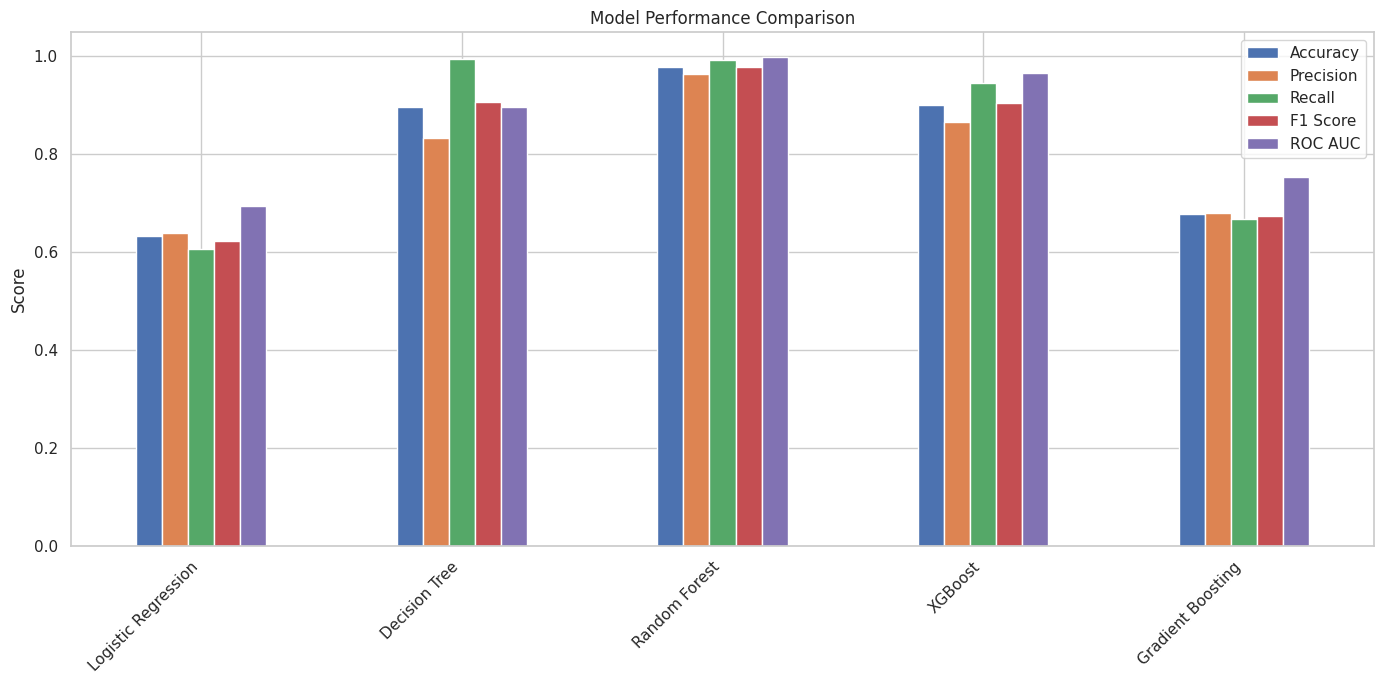

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1] # Probability for the positive class

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{name} Evaluation Complete.\n")

# Display results in a DataFrame
results_df = pd.DataFrame(results).T
print("Model Performance Metrics:")
print(results_df)

# Determine the best model based on a chosen metric (e.g., ROC AUC)
best_model_name = results_df['ROC AUC'].idxmax()
print(f"\nThe best model based on ROC AUC is: {best_model_name}")

# Optional: Visualize the results
results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].plot(kind='bar', figsize=(14, 7))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



Confusion Matrices:

Logistic Regression Confusion Matrix:
[[1056  553]
 [ 633  976]]


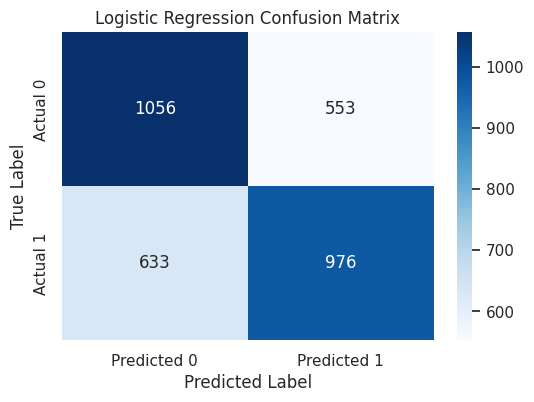


Decision Tree Confusion Matrix:
[[1285  324]
 [  10 1599]]


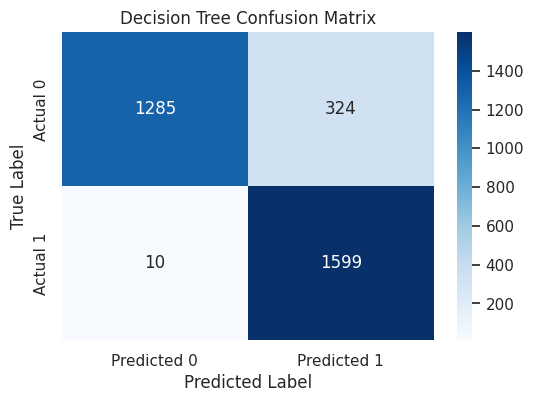


Random Forest Confusion Matrix:
[[1548   61]
 [  15 1594]]


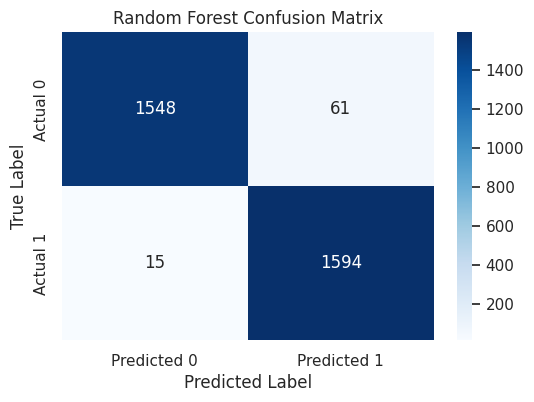


XGBoost Confusion Matrix:
[[1373  236]
 [  90 1519]]


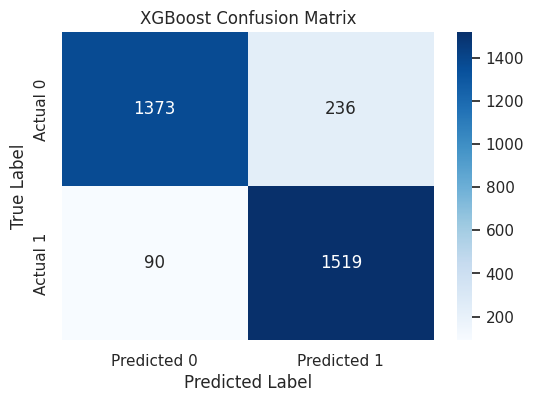


Gradient Boosting Confusion Matrix:
[[1102  507]
 [ 535 1074]]


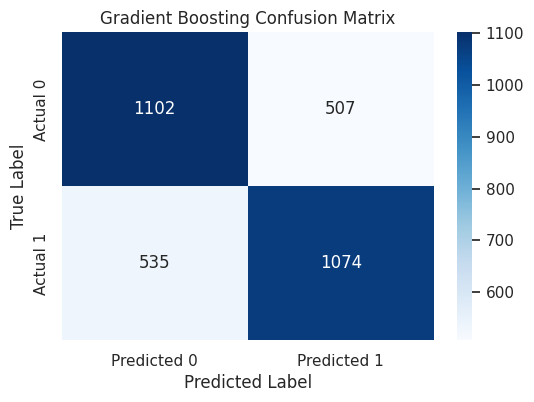


Classification Reports:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1609
           1       0.64      0.61      0.62      1609

    accuracy                           0.63      3218
   macro avg       0.63      0.63      0.63      3218
weighted avg       0.63      0.63      0.63      3218


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1609
           1       0.83      0.99      0.91      1609

    accuracy                           0.90      3218
   macro avg       0.91      0.90      0.90      3218
weighted avg       0.91      0.90      0.90      3218


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1609
           1       0.96      0.99      0.98      1609

    accuracy                         

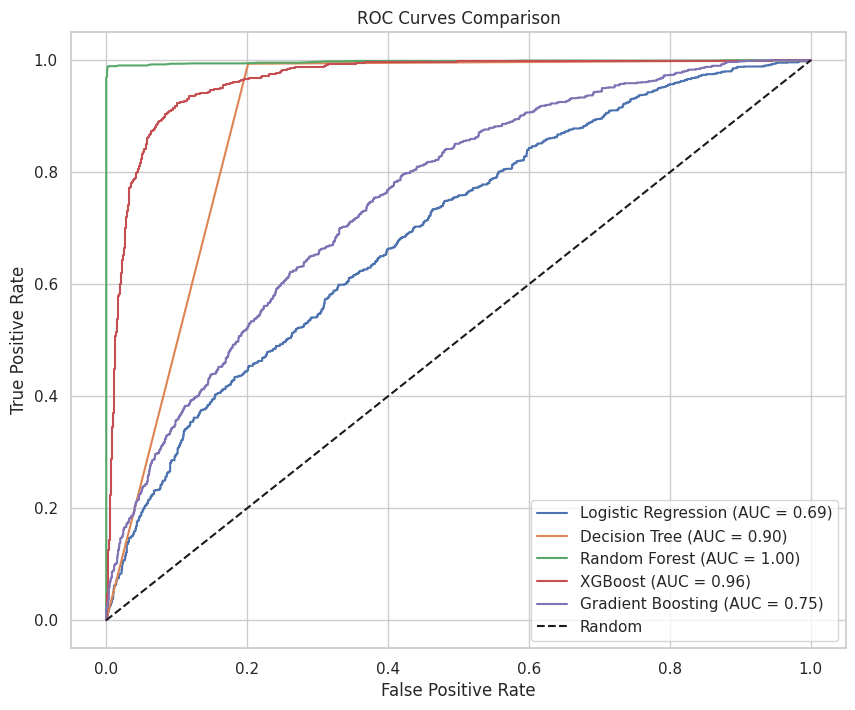


Performing Cross-Validation for the best model: Random Forest
Cross-validation ROC AUC scores: [0.50673421 0.50371066 0.49347217 0.53068187 0.51891094]
Mean cross-validation ROC AUC: 0.5107
Standard deviation of cross-validation ROC AUC: 0.0129

Feature Importance:

Decision Tree Feature Importance:
int.rate                      0.124596
log.annual.inc                0.105116
days.with.cr.line             0.094933
revol.bal                     0.090043
dti                           0.087165
loan_to_income                0.080748
revol.util                    0.078418
credit_utilization            0.071164
fico                          0.058596
installment                   0.039170
debt_to_income_ratio          0.035502
inq.last.6mths                0.030514
credit.policy                 0.024637
payment_to_income_ratio       0.022519
delinq.2yrs                   0.015007
purpose_home_improvement      0.007669
purpose_small_business        0.007541
pub.rec                       0.007

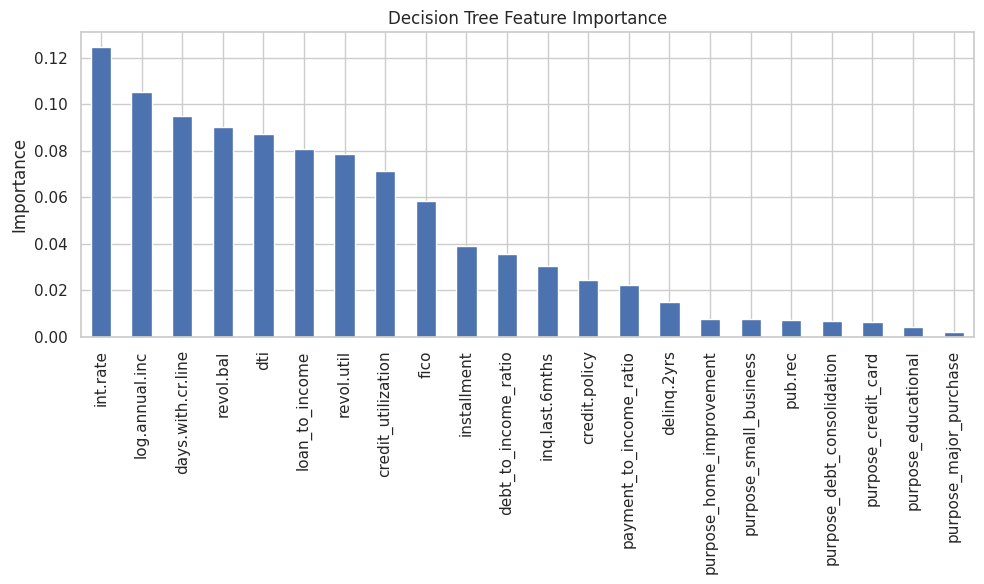


Random Forest Feature Importance:
int.rate                      0.087817
loan_to_income                0.080012
days.with.cr.line             0.078920
revol.util                    0.076172
log.annual.inc                0.075631
credit_utilization            0.074649
dti                           0.074349
revol.bal                     0.073388
installment                   0.066432
payment_to_income_ratio       0.066139
debt_to_income_ratio          0.065250
fico                          0.064908
inq.last.6mths                0.041670
credit.policy                 0.019072
purpose_debt_consolidation    0.011313
delinq.2yrs                   0.009641
purpose_credit_card           0.007879
purpose_small_business        0.007592
pub.rec                       0.006303
purpose_home_improvement      0.004785
purpose_major_purchase        0.004054
purpose_educational           0.004025
dtype: float64


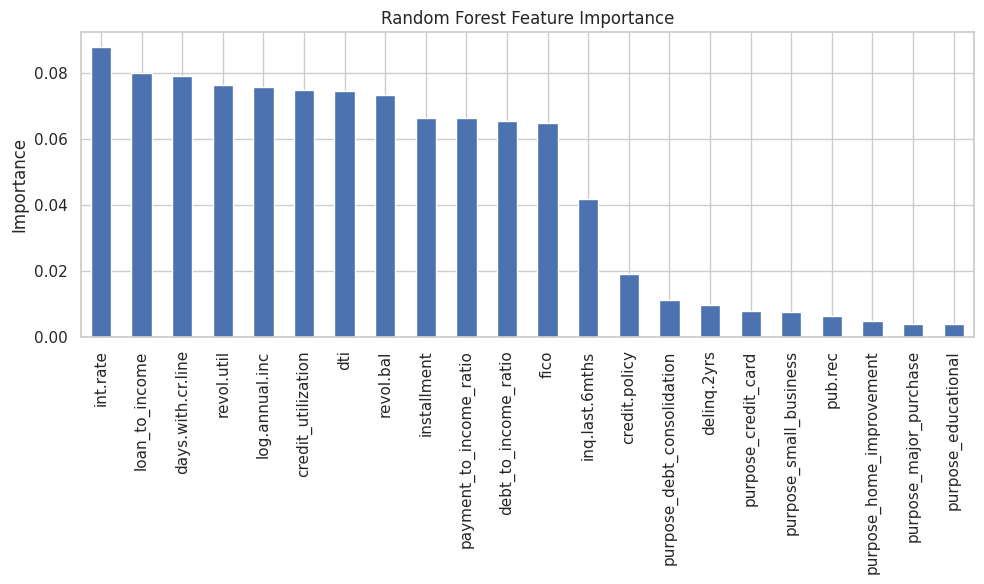


XGBoost Feature Importance:
credit.policy                 0.145486
purpose_small_business        0.060360
int.rate                      0.058703
purpose_major_purchase        0.055738
purpose_credit_card           0.050685
inq.last.6mths                0.045308
purpose_educational           0.043335
debt_to_income_ratio          0.041560
pub.rec                       0.041555
loan_to_income                0.041459
log.annual.inc                0.041132
credit_utilization            0.040470
delinq.2yrs                   0.040214
purpose_debt_consolidation    0.040066
days.with.cr.line             0.038864
fico                          0.038814
revol.util                    0.037925
revol.bal                     0.037639
dti                           0.036936
installment                   0.036869
purpose_home_improvement      0.026882
payment_to_income_ratio       0.000000
dtype: float32


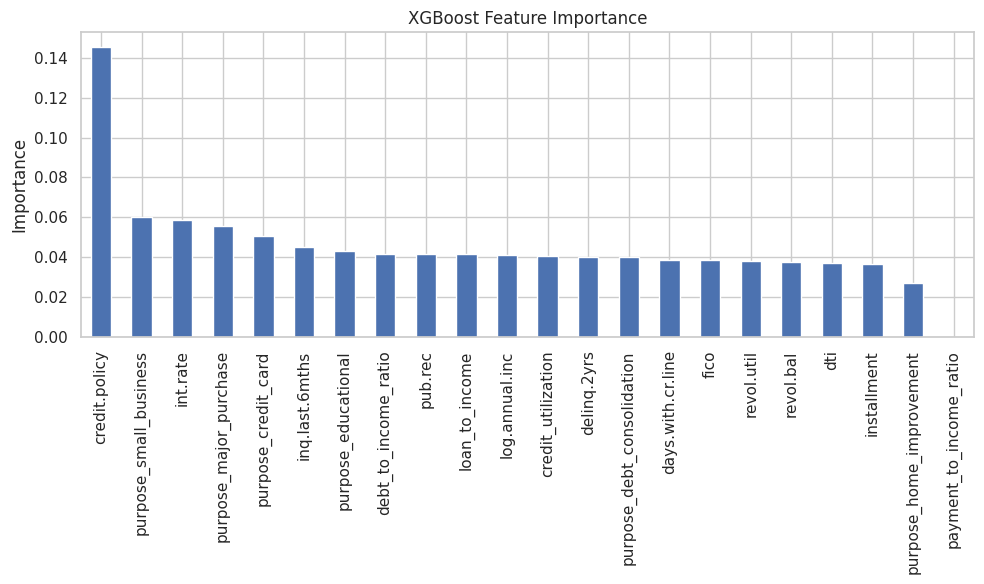


Gradient Boosting Feature Importance:
int.rate                      0.222780
credit.policy                 0.093804
loan_to_income                0.087804
log.annual.inc                0.079699
inq.last.6mths                0.073773
days.with.cr.line             0.065922
fico                          0.065323
revol.util                    0.052268
credit_utilization            0.045232
dti                           0.034509
installment                   0.032221
revol.bal                     0.032059
purpose_small_business        0.022772
purpose_credit_card           0.021465
debt_to_income_ratio          0.020008
purpose_debt_consolidation    0.017755
pub.rec                       0.015637
payment_to_income_ratio       0.011033
delinq.2yrs                   0.004147
purpose_major_purchase        0.001151
purpose_home_improvement      0.000639
purpose_educational           0.000000
dtype: float64


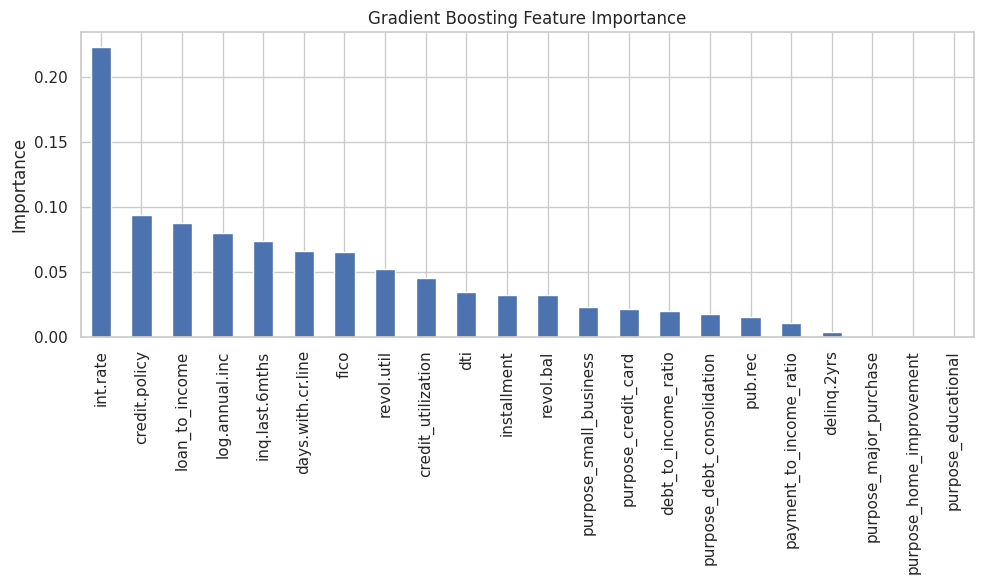


Fairness Analysis:

Fairness analysis for Logistic Regression:


ValueError: Found input variables with inconsistent numbers of samples: [1916, 3218]

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference

# Confusion Matrix
print("\nConfusion Matrices:")
for name, model in models.items():
    print(f"\n{name} Confusion Matrix:")
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Classification Report
print("\nClassification Reports:")
for name, model in models.items():
    print(f"\n{name} Classification Report:")
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))

# ROC Curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

# Cross-Validation (Using the best model)
print(f"\nPerforming Cross-Validation for the best model: {best_model_name}")
best_model = models[best_model_name]
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC AUC scores: {cv_scores}")
print(f"Mean cross-validation ROC AUC: {cv_scores.mean():.4f}")
print(f"Standard deviation of cross-validation ROC AUC: {cv_scores.std():.4f}")

# Feature Importance (for tree-based models)
print("\nFeature Importance:")
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        print(f"\n{name} Feature Importance:")
        importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
        print(importance)

        plt.figure(figsize=(10, 6))
        importance.plot(kind='bar')
        plt.title(f'{name} Feature Importance')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()

# Fairness Analysis with Fairlearn
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure 'sensitive_attribute_name' exists in X_test_orig
if sensitive_attribute_name in X_test_orig.columns:
    A_test = X_test_orig[sensitive_attribute_name].reset_index(drop=True)
else:
    raise KeyError(f"Error: '{sensitive_attribute_name}' column not found in X_test_orig. Please check preprocessing steps.")

# Align indices between A_test and y_test
y_test = y_test.reset_index(drop=True)
A_test = A_test.reset_index(drop=True)

print("\nFairness Analysis:")
for name, model in models.items():
    print(f"\nFairness analysis for {name}:")
    y_pred = model.predict(X_test_scaled)

    fairness_metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score
    }

    # Compute fairness metrics separately
    dp_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test)
    eo_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test)

    metric_frame = MetricFrame(metrics=fairness_metrics,
                               y_true=y_test,
                               y_pred=y_pred,
                               sensitive_features=A_test)

    print(metric_frame.by_group)

    metric_frame.by_group.plot(kind='bar', legend=True, figsize=(10, 6),
                               title=f'{name} Performance by {sensitive_attribute_name}')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(f"Demographic Parity Difference: {dp_diff:.4f}")
    print(f"Equalized Odds Difference: {eo_diff:.4f}")

print("\nEvaluation and Metrics Analysis Complete.")


In [119]:
print("Shape of y_test:", y_test.shape)
print("Shape of A_test:", A_test.shape)
print("Shape of sensitive attribute column:", A_test[sensitive_attribute_name].shape)


Shape of y_test: (3218,)
Shape of A_test: (1916,)


KeyError: 'fico'

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Define parameter space for a chosen model, e.g., RandomForestClassifier
# You would choose the model that performed best based on the previous evaluation
param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'bootstrap': Categorical([True, False])
}

# Initialize the best model found in the previous step
best_model = models[best_model_name]

# Initialize BayesSearchCV
# n_iter: Number of parameter settings that are sampled.
# cv: Cross-validation splitting strategy
# scoring: Strategy to evaluate the performance of the cross-validated model on the test set.
# n_jobs: Number of jobs to run in parallel. -1 means using all processors.
bayes_search = BayesSearchCV(
    estimator=best_model,
    search_spaces=param_space,
    n_iter=50,  # You can adjust the number of iterations
    cv=5,
    scoring='roc_auc',  # Use the same metric as before
    random_state=42,
    n_jobs=-1
)

print(f"Running Bayesian Optimization for {best_model_name}...")

# Fit the Bayesian Search to the scaled training data
bayes_search.fit(X_train_scaled, y_train)

print("\nBayesian Optimization Complete.")

# Get the best parameters and best score
print("Best parameters found:", bayes_search.best_params_)
print("Best ROC AUC score found:", bayes_search.best_score_)

# Evaluate the best model found by Bayesian Optimization on the test set
best_tuned_model = bayes_search.best_estimator_
y_pred_tuned = best_tuned_model.predict(X_test_scaled)
y_prob_tuned = best_tuned_model.predict_proba(X_test_scaled)[:, 1]

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_prob_tuned)

print("\nEvaluation of the Tuned Model:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")
print(f"ROC AUC: {roc_auc_tuned:.4f}")

# Compare with the performance of the untuned best model
print("\nComparison with the Untuned Best Model:")
print(f"Untuned ROC AUC: {results[best_model_name]['ROC AUC']:.4f}")
print(f"Tuned ROC AUC: {roc_auc_tuned:.4f}")


###1. Interaction term between 'int.rate' and 'fico'.
Rationale: The interest rate a person receives is often influenced by their credit score (FICO).
 An interaction term can capture how these two features jointly affect the target variable.

###2. A ratio of 'revol.bal' to 'log.annual.inc'.
Rationale: This ratio can represent the proportion of revolving balance relative to annual income, which might indicate financial strain or leverage.

###3. A feature representing the number of inquiries per year.
 Rationale: While 'inq.last.6mths' captures recent inquiries, understanding the frequency over the
 entire credit history ('days.with.cr.line') might be a better indicator of credit-seeking behavior.
 Convert days to years by dividing by 365.25 to account for leap years.

###4. A combined feature for negative credit events.
Rationale: Summing up 'delinq.2yrs' and 'pub.rec' can create a single metric for past negative credit history.

###5. A feature for the inverse of FICO score.
 Rationale: Sometimes, the relationship between a score and the target is not linear. The inverse might capture this non-linearity.

## 4. Model Selection and Training


BIAS DETECTION AND FAIRNESS AUDITS

In [ ]:
print("\n--- Fairness Assessment of Logistic Regression Model (Unmitigated) ---")

# Evaluate fairness metrics using MetricFrame, grouped by the sensitive attribute
grouped_on_credit_policy = MetricFrame(metrics={
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'roc_auc': roc_auc_score
}, y_true=y_test, y_pred=y_pred_lr, sensitive_features=A_test)

print(f"\nPerformance metrics grouped by '{sensitive_attribute_name}':")
print(grouped_on_credit_policy.by_group.to_markdown())

# Calculate fairness disparities
dem_parity_diff = demographic_parity_difference(y_true=y_test, y_pred=y_pred_lr, sensitive_features=A_test)
eq_odds_diff = equalized_odds_difference(y_true=y_test, y_pred=y_pred_lr, sensitive_features=A_test)

print(f"\nDemographic Parity Difference (y_pred): {dem_parity_diff:.4f}")
print(f"Equalized Odds Difference (y_pred): {eq_odds_diff:.4f}")

print("\n--- Training Logistic Regression with Bias Mitigation (Equalized Odds) ---")

# Ensure Pipeline is imported
from sklearn.pipeline import Pipeline


from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Identify numerical and categorical features excluding the sensitive attribute
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
# Exclude the sensitive attribute from numerical features if it was numerical
if sensitive_attribute_name in numerical_features:
    numerical_features.remove(sensitive_attribute_name)

categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# Create a preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Define the unmitigated estimator within the pipeline
# This pipeline will be used by GridSearch as the base estimator
unmitigated_estimator = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

# GridSearch aims to find a predictor that satisfies approximate fairness constraints
# It explores a grid of Lagrange multipliers to find optimal trade-offs between accuracy and fairness.
mitigated_estimator = GridSearch(
    unmitigated_estimator,
    constraints=EqualizedOdds(),
    grid_size=60,
    sample_weight_name="classifier__sample_weight"
)

# Fitting the mitigated estimator.
mitigated_estimator.fit(X_train, y_train, sensitive_features=A_train)

# Make predictions with the mitigated model
y_pred_mitigated = mitigated_estimator.predict(X_test)
y_proba_mitigated = mitigated_estimator.predict_proba(X_test)[:, 1] # Get probabilities for ROC-AUC

# Evaluate standard performance metrics for the mitigated Logistic Regression
accuracy_mitigated = accuracy_score(y_test, y_pred_mitigated)
precision_mitigated = precision_score(y_test, y_pred_mitigated)
recall_mitigated = recall_score(y_test, y_pred_mitigated)
f1_mitigated = f1_score(y_test, y_pred_mitigated)
roc_auc_mitigated = roc_auc_score(y_test, y_proba_mitigated)

print(f"\nMitigated Model Performance:")
print(f"Accuracy: {accuracy_mitigated:.4f}")
print(f"Precision: {precision_mitigated:.4f}")
print(f"Recall: {recall_mitigated:.4f}")
print(f"F1-Score: {f1_mitigated:.4f}")
print(f"ROC-AUC: {roc_auc_mitigated:.4f}")

print("\n--- Fairness Assessment of Mitigated Logistic Regression Model ---")

# Evaluate fairness metrics using MetricFrame for the mitigated model
grouped_on_credit_policy_mitigated = MetricFrame(metrics={
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score,
    'roc_auc': roc_auc_score
}, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=A_test)

print(f"\nPerformance metrics grouped by '{sensitive_attribute_name}' (Mitigated Model):")
print(grouped_on_credit_policy_mitigated.by_group.to_markdown())

dem_parity_diff_mitigated = demographic_parity_difference(y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=A_test)
eq_odds_diff_mitigated = equalized_odds_difference(y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=A_test)

print(f"\nDemographic Parity Difference (y_pred, Mitigated): {dem_parity_diff_mitigated:.4f}")
print(f"Equalized Odds Difference (y_pred, Mitigated): {eq_odds_diff_mitigated:.4f}")

print("\n--- Summary of Fairness and Performance Trade-off ---")
print(f"Unmitigated Equalized Odds Difference: {eq_odds_diff:.4f}")
print(f"Mitigated Equalized Odds Difference:   {eq_odds_diff_mitigated:.4f}")
print(f"Improvement in Equalized Odds Difference: {abs(eq_odds_diff - eq_odds_diff_mitigated):.4f}")

print(f"\nUnmitigated ROC-AUC: {roc_auc_lr:.4f}")
print(f"Mitigated ROC-AUC:   {roc_auc_mitigated:.4f}")
print(f"Change in ROC-AUC: {roc_auc_mitigated - roc_auc_lr:.4f}")

print("\n**Interpretation:**")
print("The 'Equalized Odds Difference' measures how much the true positive rate and false positive rate vary across different groups of the sensitive attribute. A smaller difference indicates better fairness.")
print("Comparing the 'Unmitigated' and 'Mitigated' results will show if the bias mitigation technique reduced this difference, ideally without significantly sacrificing overall model performance (e.g., ROC-AUC).")







--- Fairness Assessment of Logistic Regression Model (Unmitigated) ---

Performance metrics grouped by 'fico':
|   fico |   accuracy |   precision |   recall |       f1 |    roc_auc |
|-------:|-----------:|------------:|---------:|---------:|-----------:|
|    632 |   1        |    0        | 0        | 0        | nan        |
|    642 |   0.357143 |    0        | 0        | 0        | nan        |
|    647 |   0.575    |    0        | 0        | 0        | nan        |
|    652 |   0.371429 |    0        | 0        | 0        | nan        |
|    657 |   0.390244 |    0        | 0        | 0        | nan        |
|    662 |   0.863309 |    0.92381  | 0.898148 | 0.910798 |   0.820042 |
|    667 |   0.87218  |    0.909091 | 0.918367 | 0.913706 |   0.830612 |
|    672 |   0.863636 |    0.912088 | 0.892473 | 0.902174 |   0.843672 |
|    677 |   0.903226 |    0.927835 | 0.947368 | 0.9375   |   0.852995 |
|    682 |   0.921986 |    0.940678 | 0.965217 | 0.95279  |   0.847993 |
|    687 |  


Mitigated Model Performance:
Accuracy: 0.8302
Precision: 0.8508
Recall: 0.9568
F1-Score: 0.9007
ROC-AUC: 0.7297

--- Fairness Assessment of Mitigated Logistic Regression Model ---

Performance metrics grouped by 'fico' (Mitigated Model):
|   fico |   accuracy |   precision |   recall |       f1 |    roc_auc |
|-------:|-----------:|------------:|---------:|---------:|-----------:|
|    632 |   1        |    0        | 0        | 0        | nan        |
|    642 |   0.25     |    0        | 0        | 0        | nan        |
|    647 |   0.3      |    0        | 0        | 0        | nan        |
|    652 |   0.2      |    0        | 0        | 0        | nan        |
|    657 |   0.268293 |    0        | 0        | 0        | nan        |
|    662 |   0.748201 |    0.823009 | 0.861111 | 0.841629 |   0.607975 |
|    667 |   0.714286 |    0.754237 | 0.908163 | 0.824074 |   0.539796 |
|    672 |   0.757576 |    0.796117 | 0.88172  | 0.836735 |   0.671629 |
|    677 |   0.83871  |    0.83